In [2]:
import torch
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import CLIPTextModel, CLIPTokenizer



/home/tony/anaconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
model_path = "stable-diffusion-v1-5/stable-diffusion-v1-5"
placeholder_token = "<celebA>"
embedding_path = "outputs/celebA_342_ti/learned_embeds.bin"
intermediate_path = "outputs/celebA_342_ti/learned_embeds-steps-{}.bin"
exp_name = "celebA_342_ti"
words = ["<celebA>",  '<|startoftext|>', '<|endoftext|>', 'man', 'woman', 'person', 'male', 'female', 'kid']
sub_words = ['man', 'woman', 'person', 'male', 'female', 'kid']
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'black', 'pink', 'gray', 'brown', 'white', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron']
reference_token = "man"

# model_path = "stable-diffusion-v1-5/stable-diffusion-v1-5"
# placeholder_token = "<celebA>"
# embedding_path = "outputs/celebA_342_norm_ti_v1_rho3.5/learned_embeds.bin"
# exp_name = "celebA_342_norm_ti_v1_rho3.5"
# words = ["<celebA>",  '<|startoftext|>', '<|endoftext|>', 'man', 'woman', 'person', 'male', 'female', 'kid']
# sub_words = ['man', 'woman', 'person', 'male', 'female', 'kid']
# colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'black', 'pink', 'gray', 'brown', 'white', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron']



# model_path = "stable-diffusion-v1-5/stable-diffusion-v1-5"
# placeholder_token = "<cat-toy>"
# embedding_path = "outputs/cat_toy_ti/learned_embeds.bin"
# intermediate_path = "outputs/cat_toy_ti/learned_embeds-steps-{}.bin"
# exp_name = "cat_toy_ti"
# words = ["<cat-toy>",  '<|startoftext|>', '<|endoftext|>', 'toy', 'cat', 'dog', 'doll', 'game', 'teddy']
# sub_words = ['toy', 'cat', 'dog', 'doll', 'game', 'teddy']
# colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'black', 'pink', 'gray', 'brown', 'white', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron', 'gold', 'silver', 'bronze', 'copper', 'aluminum', 'steel', 'iron']
# reference_token = "toy"

tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_path, subfolder="text_encoder")

placeholder_token = [f"{placeholder_token}"]
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError("The tokens are already in the tokenizer")
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)
text_encoder.resize_token_embeddings(len(tokenizer))

text_encoder.to("cuda")

if os.path.exists(embedding_path):
    learned_embeds = torch.load(embedding_path)
    token_embeds = text_encoder.get_input_embeddings().weight.data
    for token, token_id in zip(placeholder_token, placeholder_token_id):
        token_embeds[token_id] = learned_embeds[token]

reference_embed = text_encoder.get_input_embeddings().weight.data[tokenizer.convert_tokens_to_ids(reference_token)]

/tmp/ipykernel_1573461/33794593.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learned_embeds = torch.load(embedding_path)


/tmp/ipykernel_1573461/3553354098.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


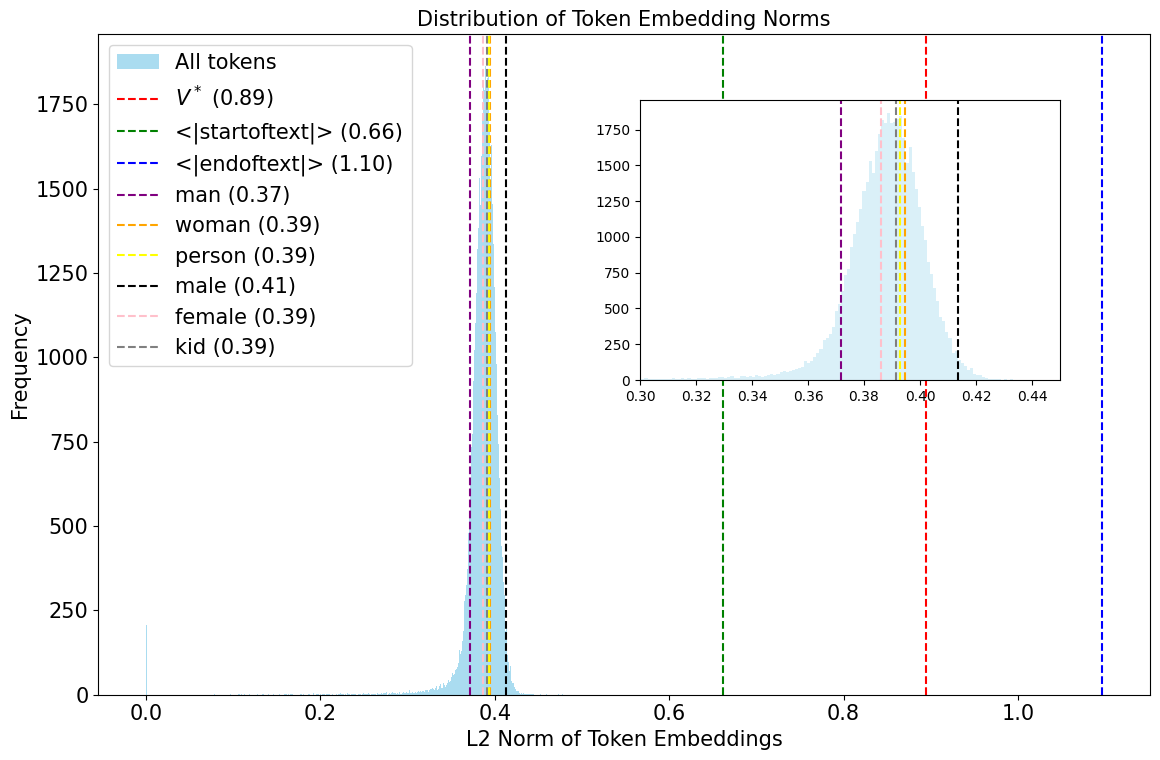

In [73]:
fontsize = 15
line_width = 2

def get_label(word):
    if word == "<celebA>":
        return r'$V^*$'
    elif word == "<cat-toy>":
        return r'$V^*$'
    else:
        return word

words_ids = tokenizer.convert_tokens_to_ids(words)
vocab = tokenizer.get_vocab()

for word in words:
    assert word in vocab, f"{word} is not in the vocabulary"

assert len(words_ids) == len(words)

# Calculate the L2 norm of all token embeddings
token_embeds = text_encoder.get_input_embeddings().weight.data
all_norms = torch.norm(token_embeds, dim=1).cpu().numpy()

# Get the norms of the specific tokens we're interested in
specific_norms = all_norms[words_ids]
specific_words = words

assert len(specific_norms) == len(specific_words)

# Plot histogram of all norms and highlight our specific tokens
fig = plt.figure(figsize=(12, 8))
main_ax = fig.add_subplot(111)
main_ax.hist(all_norms, bins=1000, alpha=0.7, color='skyblue', label='All tokens')

# Add vertical lines for our specific tokens with different colors
for i, (word, norm) in enumerate(zip(specific_words, specific_norms)):
    main_ax.axvline(x=norm, color=colors[i], linestyle='--', 
                label=f'{get_label(word)} ({norm:.2f})')

main_ax.set_xlabel('L2 Norm of Token Embeddings', fontsize=fontsize)
main_ax.set_ylabel('Frequency', fontsize=fontsize)
main_ax.set_title('Distribution of Token Embedding Norms', fontsize=fontsize)
main_ax.tick_params(axis='both', which='major', labelsize=fontsize)
main_ax.legend(fontsize=fontsize)
# main_ax.grid(alpha=0.3)

# Create a subfigure in the top right corner
# First, create a smaller axis in the top right
sub_ax = fig.add_axes([0.55, 0.5, 0.35, 0.35])  # [left, bottom, width, height]

# Filter for just the tokens we want in the subfigure

sub_indices = [words.index(word) for word in sub_words]
sub_norms = [specific_norms[i] for i in sub_indices]
sub_colors = [colors[i] for i in sub_indices]

# Plot the subfigure with just these tokens
for i, (word, norm) in enumerate(zip(sub_words, sub_norms)):
    sub_ax.axvline(x=norm, color=sub_colors[i], linestyle='--', 
                label=f'{get_label(word)} ({norm:.2f})')

# Set appropriate x-limits for the subfigure
# min_norm = min(sub_norms) - 0.5
# max_norm = max(sub_norms) + 0.5
min_norm = 0.3
max_norm = 0.45
sub_ax.set_xlim(min_norm, max_norm)
sub_ax.tick_params(axis='both', which='major', labelsize=10)

# Add a small histogram in the background of the subfigure
sub_ax.hist(all_norms, bins=1000, alpha=0.3, color='skyblue', label='All tokens')
# sub_ax.set_title('Common Words Comparison')
# sub_ax.legend()
# sub_ax.grid(alpha=0.3)

# plt.show()
plt.tight_layout()
plt.savefig(f'results/token_norm_distribution_{exp_name}.png', bbox_inches='tight', dpi=300)

/tmp/ipykernel_1573461/1893211994.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learned_embeds = torch.load(embedding_path)
/tmp/ipykernel_1573461/1893211994.py:128: 

[array(0.3873222, dtype=float32), array(0.47218543, dtype=float32), array(0.5055776, dtype=float32), array(0.5291749, dtype=float32), array(0.55097806, dtype=float32), array(0.566572, dtype=float32), array(0.5820278, dtype=float32), array(0.5993556, dtype=float32), array(0.6198028, dtype=float32), array(0.634391, dtype=float32), array(0.65386605, dtype=float32), array(0.6664883, dtype=float32), array(0.68356794, dtype=float32), array(0.69660074, dtype=float32), array(0.71277267, dtype=float32), array(0.73071593, dtype=float32), array(0.74578893, dtype=float32), array(0.756861, dtype=float32), array(0.7711359, dtype=float32), array(0.78152514, dtype=float32), array(0.79305476, dtype=float32), array(0.8058087, dtype=float32), array(0.8163565, dtype=float32), array(0.82755435, dtype=float32), array(0.8390631, dtype=float32), array(0.8512761, dtype=float32), array(0.8635608, dtype=float32), array(0.8725762, dtype=float32), array(0.88306004, dtype=float32)]
[array([0.41064668], dtype=float3

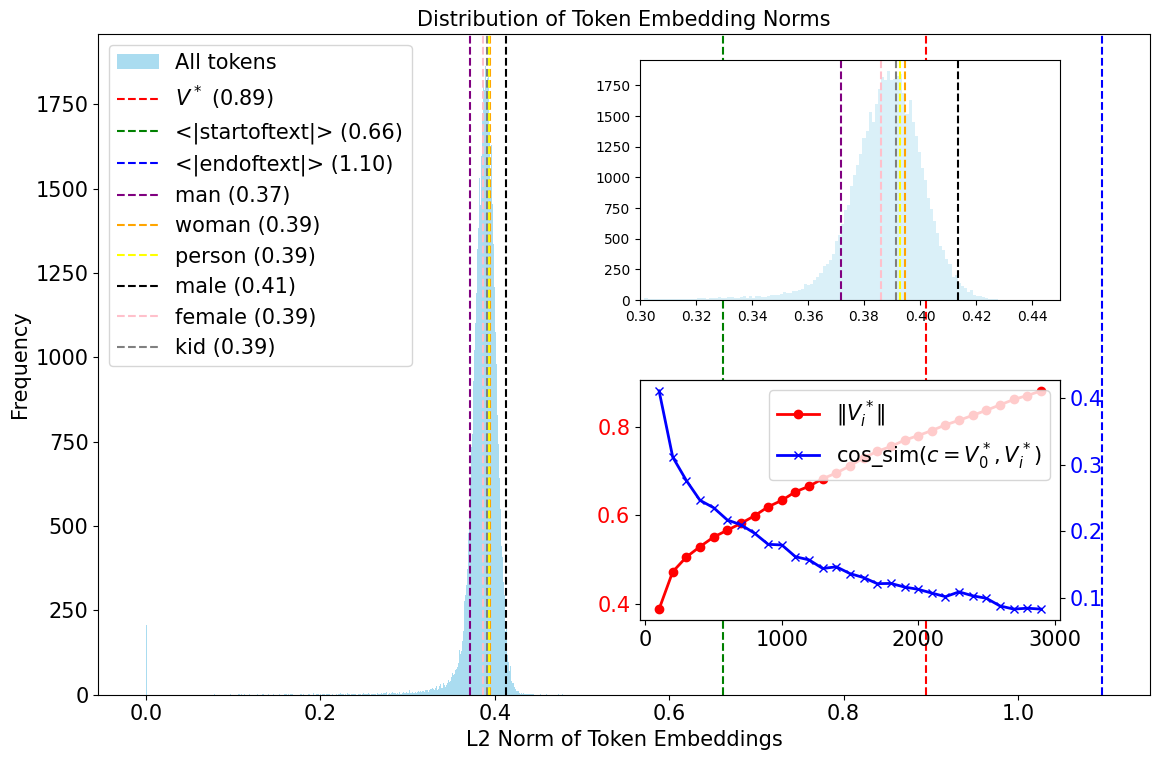

In [74]:
fontsize = 15
line_width = 2

def get_label(word):
    if word == "<celebA>":
        return r'$V^*$'
    elif word == "<cat-toy>":
        return r'$V^*$'
    else:
        return word

words_ids = tokenizer.convert_tokens_to_ids(words)
vocab = tokenizer.get_vocab()

for word in words:
    assert word in vocab, f"{word} is not in the vocabulary"

assert len(words_ids) == len(words)

# Calculate the L2 norm of all token embeddings
token_embeds = text_encoder.get_input_embeddings().weight.data
all_norms = torch.norm(token_embeds, dim=1).cpu().numpy()

# Get the norms of the specific tokens we're interested in
specific_norms = all_norms[words_ids]
specific_words = words

assert len(specific_norms) == len(specific_words)

# Plot histogram of all norms and highlight our specific tokens
fig = plt.figure(figsize=(12, 8))
main_ax = fig.add_subplot(111)
main_ax.hist(all_norms, bins=1000, alpha=0.7, color='skyblue', label='All tokens')

# Add vertical lines for our specific tokens with different colors
for i, (word, norm) in enumerate(zip(specific_words, specific_norms)):
    main_ax.axvline(x=norm, color=colors[i], linestyle='--', 
                label=f'{get_label(word)} ({norm:.2f})')

main_ax.set_xlabel('L2 Norm of Token Embeddings', fontsize=fontsize)
main_ax.set_ylabel('Frequency', fontsize=fontsize)
main_ax.set_title('Distribution of Token Embedding Norms', fontsize=fontsize)
main_ax.tick_params(axis='both', which='major', labelsize=fontsize)
main_ax.legend(fontsize=fontsize)
# main_ax.grid(alpha=0.3)

# Create a subfigure in the top right corner
# First, create a smaller axis in the top right
sub_ax = fig.add_axes([0.55, 0.6, 0.35, 0.3])  # [left, bottom, width, height]

# Filter for just the tokens we want in the subfigure

sub_indices = [words.index(word) for word in sub_words]
sub_norms = [specific_norms[i] for i in sub_indices]
sub_colors = [colors[i] for i in sub_indices]

# Plot the subfigure with just these tokens
for i, (word, norm) in enumerate(zip(sub_words, sub_norms)):
    sub_ax.axvline(x=norm, color=sub_colors[i], linestyle='--', 
                label=f'{get_label(word)} ({norm:.2f})')

# Set appropriate x-limits for the subfigure
# min_norm = min(sub_norms) - 0.5
# max_norm = max(sub_norms) + 0.5
min_norm = 0.3
max_norm = 0.45
sub_ax.set_xlim(min_norm, max_norm)
sub_ax.tick_params(axis='both', which='major', labelsize=10)

# Add a small histogram in the background of the subfigure
sub_ax.hist(all_norms, bins=1000, alpha=0.3, color='skyblue', label='All tokens')
# sub_ax.set_title('Common Words Comparison')
# sub_ax.legend()
# sub_ax.grid(alpha=0.3)

# create another subfigure in the bottom right corner
sub_ax2 = fig.add_axes([0.55, 0.2, 0.35, 0.3])

reference_embed = text_encoder.get_input_embeddings().weight.data[tokenizer.convert_tokens_to_ids(reference_token)]
all_norms = []
all_cos_sims = []
iters = []
for i in range(3000):
    embedding_path = intermediate_path.format(i)
    if os.path.exists(embedding_path):
        learned_embeds = torch.load(embedding_path)
        for token, token_id in zip(placeholder_token, placeholder_token_id):
            specific_token_embed = learned_embeds[token]
        specific_token_embed = specific_token_embed.squeeze(0)
        # print(specific_token_embed.shape)
        # print(reference_embed.shape)
        norms = torch.norm(specific_token_embed, dim=0)
        cos_sim = torch.nn.functional.cosine_similarity(specific_token_embed.unsqueeze(0).cpu(), reference_embed.unsqueeze(0).cpu(), dim=1)
        all_norms.append(norms.cpu().numpy())
        all_cos_sims.append(cos_sim.cpu().numpy())
        iters.append(i)
print(all_norms) 
print(all_cos_sims)

all_norms = np.array(all_norms)
all_cos_sims = np.array(all_cos_sims)


all_norms = np.array(all_norms)
all_cos_sims = np.array(all_cos_sims)

# Use the existing subfigure instead of creating a new figure
ax1 = sub_ax2
ax1.plot(iters, all_norms, label=r'$\|V^*_i\|$', marker='o', color='red', linewidth=line_width)
# ax1.set_ylabel('Norm', color='red', fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor='red', labelsize=fontsize)

# Create second y-axis and plot cosine similarities
ax2 = ax1.twinx()
ax2.plot(iters, all_cos_sims, label=r'$\text{cos_sim}(c=V^*_0, V^*_i)$', marker='x', color='blue', linewidth=line_width)
# ax2.set_ylabel('Cosine Similarity', color='blue', fontsize=fontsize)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=fontsize)

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=fontsize)
# ax1.set_xlabel('Iteration', fontsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)


# plt.show()
plt.tight_layout()
plt.savefig(f'results/token_norm_distribution_{exp_name}_combine.png', bbox_inches='tight', dpi=300)

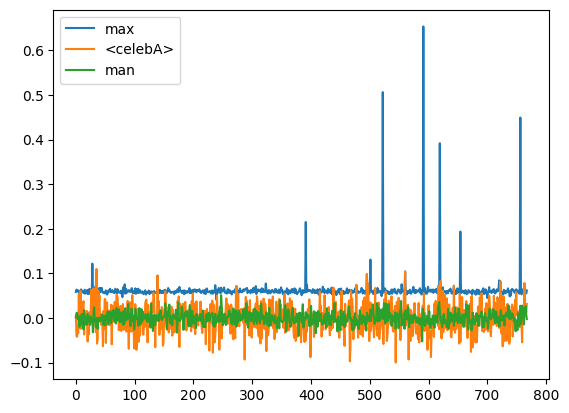

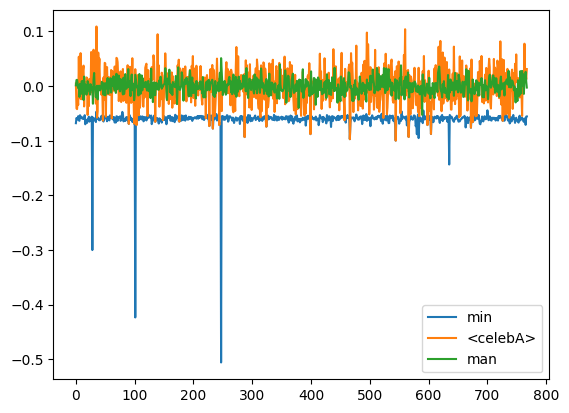

tensor([-0.0010, -0.0005,  0.0006,  0.0004, -0.0005,  0.0006,  0.0008,  0.0005,
        -0.0004, -0.0007], device='cuda:0')
tensor([0.0140, 0.0138, 0.0140, 0.0139, 0.0138, 0.0139, 0.0140, 0.0139, 0.0139,
        0.0138], device='cuda:0')
tensor([ 0.0046, -0.0408, -0.0422, -0.0282, -0.0342,  0.0538, -0.0222,  0.0020,
         0.0603, -0.0241], device='cuda:0')
tensor([ 0.0014,  0.0110,  0.0115,  0.0047, -0.0038,  0.0015, -0.0198,  0.0042,
         0.0031, -0.0141], device='cuda:0')


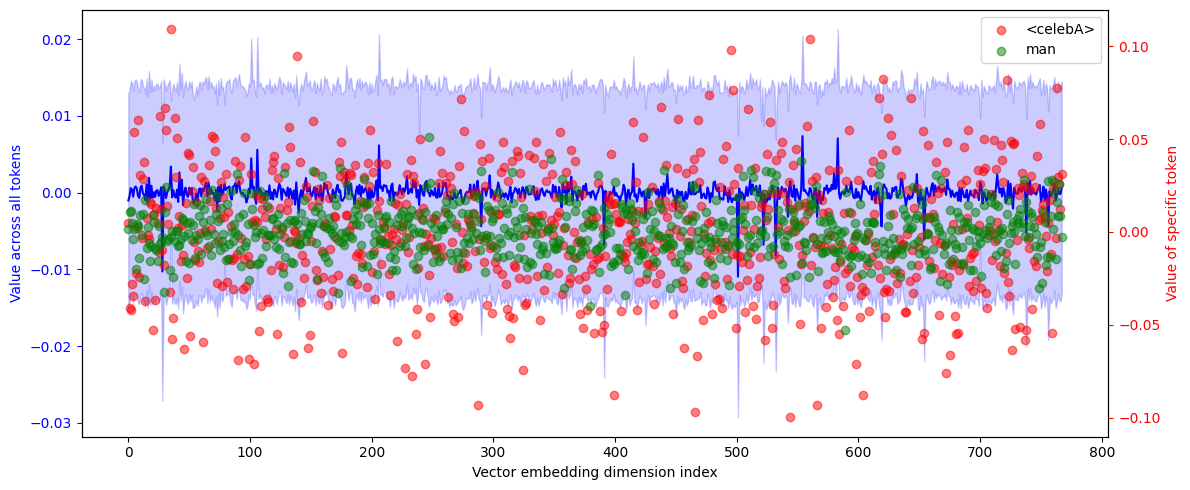

In [5]:
# token_embeds.shape [49409, 768]
# plot the max value of each row 
# words_to_plot = ['<cat-toy>', 'toy']
words_to_plot = ['<celebA>', 'man']
words_ids = tokenizer.convert_tokens_to_ids(words_to_plot)
max_values, _ = torch.max(token_embeds, axis=0)
plt.plot(max_values.cpu().numpy(), label='max')
for word, id in zip(words_to_plot, words_ids):
    plt.plot(token_embeds[id].cpu().numpy(), label=word)
plt.legend()
plt.show()

min_values, _ = torch.min(token_embeds, axis=0)
plt.plot(min_values.cpu().numpy(), label='min')
for word, id in zip(words_to_plot, words_ids):
    plt.plot(token_embeds[id].cpu().numpy(), label=word)
plt.legend()
plt.show()


# plot the mean value of each row 
mean_values = torch.mean(token_embeds, axis=0)
std_values = torch.std(token_embeds, axis=0)
print(mean_values[:10])
print(std_values[:10])

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)  # Create the main axes
ax1.plot(mean_values.cpu().numpy(), label='mean', color='blue')
ax1.fill_between(range(len(mean_values)), 
                (mean_values - std_values).cpu().numpy(),
                (mean_values + std_values).cpu().numpy(),
                alpha=0.2, color='blue', label='±std')
ax2 = ax1.twinx()  # Create second y-axis
for i, (word, id) in enumerate(zip(words_to_plot, words_ids)):
    ax2.scatter(range(len(token_embeds[id])), token_embeds[id].cpu().numpy(), label=word, alpha=0.5, color=colors[i])
    print(token_embeds[id][:10])
ax1.yaxis.set_tick_params(colors='blue')
ax1.set_ylabel('Value across all tokens', color='blue')  # Label for first y-axis
ax2.yaxis.set_tick_params(colors='red')
ax2.set_ylabel('Value of specific token', color='red')  # Label for second y-axis
ax1.set_xlabel('Vector embedding dimension index')
ax2.legend()
# plt.show()
plt.tight_layout()
plt.savefig(f'results/token_value_across_dimension_{exp_name}.png', bbox_inches='tight', dpi=300)


/tmp/ipykernel_1573461/845925860.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learned_embeds = torch.load(embedding_path)


[array(0.3873222, dtype=float32), array(0.47218543, dtype=float32), array(0.5055776, dtype=float32), array(0.5291749, dtype=float32), array(0.55097806, dtype=float32), array(0.566572, dtype=float32), array(0.5820278, dtype=float32), array(0.5993556, dtype=float32), array(0.6198028, dtype=float32), array(0.634391, dtype=float32), array(0.65386605, dtype=float32), array(0.6664883, dtype=float32), array(0.68356794, dtype=float32), array(0.69660074, dtype=float32), array(0.71277267, dtype=float32), array(0.73071593, dtype=float32), array(0.74578893, dtype=float32), array(0.756861, dtype=float32), array(0.7711359, dtype=float32), array(0.78152514, dtype=float32), array(0.79305476, dtype=float32), array(0.8058087, dtype=float32), array(0.8163565, dtype=float32), array(0.82755435, dtype=float32), array(0.8390631, dtype=float32), array(0.8512761, dtype=float32), array(0.8635608, dtype=float32), array(0.8725762, dtype=float32), array(0.88306004, dtype=float32)]
[array([0.41064668], dtype=float3

/tmp/ipykernel_1573461/845925860.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learned_embeds = torch.load(embedding_path)


torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size

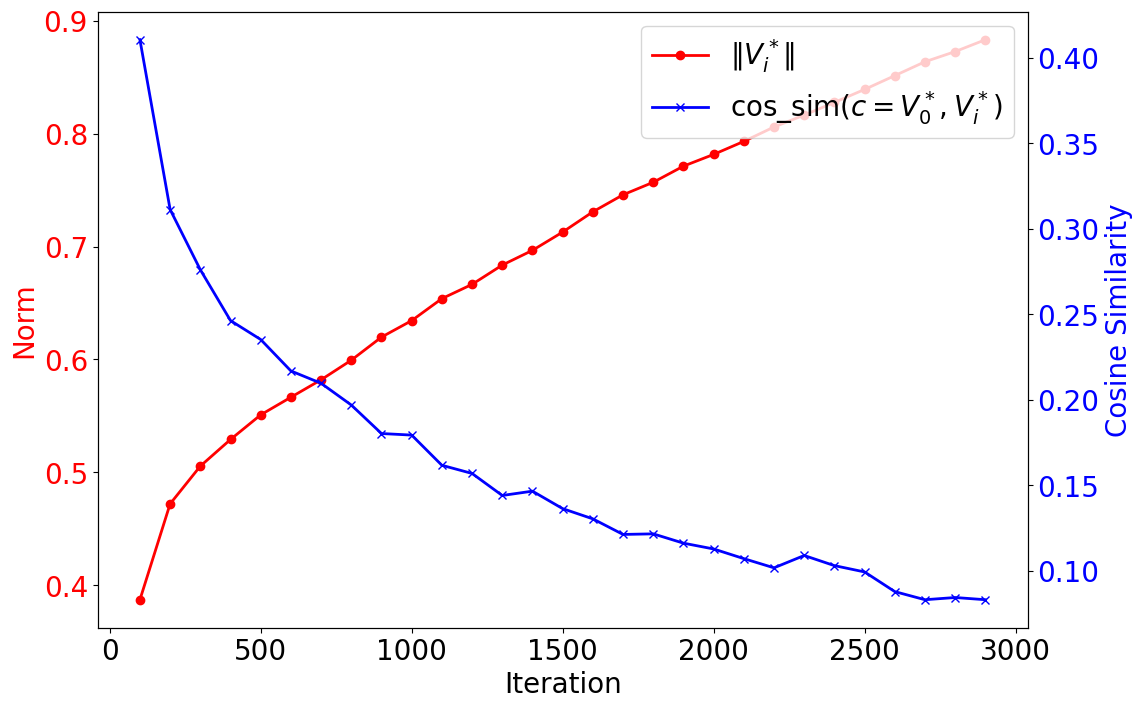

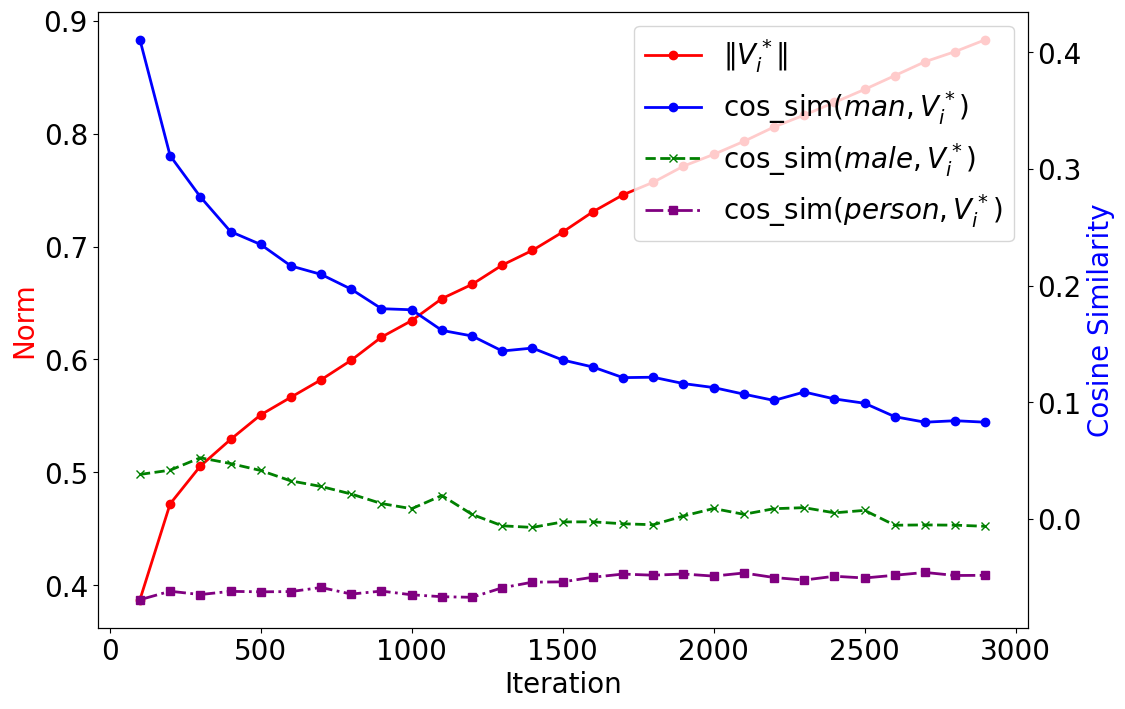

In [75]:
# plot the norm and the direction of the token embedding over the iterations
markers = ['o', 'x', 's', 'D', 'P', 'H', 'X', 'd', 'p', 'h']
colors = ['blue', 'green', 'purple', 'orange', 'yellow', 'black', 'pink', 'gray', 'brown', 'red']
lines = ['-', '--', '-.', ':', '--', '--', '-.', ':', '--', '--']

reference_token = "man"
sub_words = ['man', 'male', 'person']

# reference_token = "toy"
# sub_words = ['toy', 'cat',  'doll']
fontsize = 20
line_width = 2

reference_embed = text_encoder.get_input_embeddings().weight.data[tokenizer.convert_tokens_to_ids(reference_token)]
all_norms = []
all_cos_sims = []
iters = []
for i in range(3000):
    embedding_path = intermediate_path.format(i)
    if os.path.exists(embedding_path):
        learned_embeds = torch.load(embedding_path)
        for token, token_id in zip(placeholder_token, placeholder_token_id):
            specific_token_embed = learned_embeds[token]
        specific_token_embed = specific_token_embed.squeeze(0)
        # print(specific_token_embed.shape)
        # print(reference_embed.shape)
        norms = torch.norm(specific_token_embed, dim=0)
        cos_sim = torch.nn.functional.cosine_similarity(specific_token_embed.unsqueeze(0).cpu(), reference_embed.unsqueeze(0).cpu(), dim=1)
        all_norms.append(norms.cpu().numpy())
        all_cos_sims.append(cos_sim.cpu().numpy())
        iters.append(i)
print(all_norms) 
print(all_cos_sims)

all_norms = np.array(all_norms)
all_cos_sims = np.array(all_cos_sims)
plt.rcParams.update({'font.size': fontsize})  # Increase font size globally
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot norms on first y-axis
ax1.plot(iters, all_norms, label=r'$\|V^*_i\|$', marker='o', color='red', linewidth=line_width)
ax1.set_ylabel('Norm', color='red', fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor='red', labelsize=fontsize)

# Create second y-axis and plot cosine similarities
ax2 = ax1.twinx()
ax2.plot(iters, all_cos_sims, label=r'$\text{cos_sim}(c=V^*_0, V^*_i)$', marker='x', color='blue', linewidth=line_width)
ax2.set_ylabel('Cosine Similarity', color='blue', fontsize=fontsize)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=fontsize)

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=fontsize)
ax1.set_xlabel('Iteration', fontsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)

plt.savefig(f'results/token_norm_and_cos_sim_{exp_name}.png', bbox_inches='tight', dpi=300)


words_ids = tokenizer.convert_tokens_to_ids(words)
vocab = tokenizer.get_vocab()

for word in words:
    assert word in vocab, f"{word} is not in the vocabulary"

assert len(words_ids) == len(words)

plt.rcParams.update({'font.size': fontsize})  # Increase font size globally
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

for iw, word in enumerate(sub_words):
    all_cos_sims = []
    all_iters = []
    all_norms = []
    reference_embed = text_encoder.get_input_embeddings().weight.data[tokenizer.convert_tokens_to_ids(word)]

    for i in range(3000):
        embedding_path = intermediate_path.format(i)
        if os.path.exists(embedding_path):
            learned_embeds = torch.load(embedding_path)
            for token, token_id in zip(placeholder_token, placeholder_token_id):
                specific_token_embed = learned_embeds[token]
            specific_token_embed = specific_token_embed.squeeze(0)
            print(specific_token_embed.shape)
            print(reference_embed.shape)
            norms = torch.norm(specific_token_embed, dim=0)
            cos_sim = torch.nn.functional.cosine_similarity(specific_token_embed.unsqueeze(0).cpu(), reference_embed.unsqueeze(0).cpu(), dim=1)  
            all_norms.append(norms.cpu().numpy())
            all_cos_sims.append(cos_sim.cpu().numpy())
            all_iters.append(i)
    ax2.plot(all_iters, all_cos_sims, label=r'$\text{cos_sim}'+'('+word+r', V^*_i)$', marker=markers[iw], color=colors[iw], linestyle=lines[iw], linewidth=line_width)

ax1.plot(all_iters, all_norms, label=r'$\|V^*_i\|$', marker='o', color='red', linewidth=line_width)
# combine the legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=fontsize)
ax1.set_xlabel('Iteration', fontsize=fontsize)
ax1.set_ylabel('Norm', color='red', fontsize=fontsize)
ax2.set_ylabel('Cosine Similarity', color='blue', fontsize=fontsize)
ax1.tick_params(axis='both', labelsize=fontsize)
ax2.tick_params(axis='both', labelsize=fontsize)
plt.savefig(f'results/token_norm_and_cos_sim_{exp_name}_all_sub_words.png', bbox_inches='tight', dpi=300)






dict_keys(['<celebA>'])